<a href="https://colab.research.google.com/github/Ragini-Chatterjee-Cat/Thought_Out_Recs/blob/main/Hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################################
# PART 1: TRAINING & EVALUATION CODE
############################################

import os
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import os
print(os.listdir())  # Lists files in the current directory


['.config', 'drive', 'sample_data']


In [3]:
!pip install pyspark torch matplotlib streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:


from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# --- Initialize Spark Session & Load Data ---
spark = SparkSession.builder.appName("HackathonDPO").getOrCreate()
SHARED_FOLDER_PATH = "/content/drive/My Drive/Hackathon-Group 7/data/"

clients_sdf = spark.read.csv(os.path.join(SHARED_FOLDER_PATH, "clients.csv"), header=True, inferSchema=True)
products_sdf = spark.read.csv(os.path.join(SHARED_FOLDER_PATH, "products.csv"), header=True, inferSchema=True)
stocks_sdf = spark.read.csv(os.path.join(SHARED_FOLDER_PATH, "stocks.csv"), header=True, inferSchema=True)
stores_sdf = spark.read.csv(os.path.join(SHARED_FOLDER_PATH, "stores.csv"), header=True, inferSchema=True)
transactions_sdf = spark.read.csv(os.path.join(SHARED_FOLDER_PATH, "transactions.csv"), header=True, inferSchema=True)

# --- Merge DataFrames ---
merged_sdf = (
    transactions_sdf
    .join(clients_sdf, "ClientID", "left")
    .join(products_sdf, "ProductID", "left")
    .join(stocks_sdf, "ProductID", "left")
    .join(stores_sdf, "StoreID", "left")
)

# --- Create Aggregated User-Item Data ---
user_item_sdf = (
    merged_sdf
    .groupBy("ClientID", "ProductID")
    .agg(F.sum(transactions_sdf["Quantity"]).alias("total_qty"))
)

# --- Filter to Top 50 Items per User ---
w = Window.partitionBy("ClientID").orderBy(F.col("total_qty").desc())
filtered_user_item_sdf = (
    user_item_sdf
    .withColumn("rank", F.row_number().over(w))
    .filter("rank <= 50")
    .drop("rank")
)

# --- Build Pairwise Preference Data using quantity as an indicator ---
pairwise_sdf = (
    filtered_user_item_sdf.alias("A")
    .join(filtered_user_item_sdf.alias("B"), on="ClientID")
    .where(F.col("A.ProductID") < F.col("B.ProductID"))
    .select(
        F.col("A.ClientID").alias("ClientID"),
        F.col("A.ProductID").alias("preferred_item"),
        F.col("B.ProductID").alias("dispreferred_item"),
        F.col("A.total_qty").alias("qtyA"),
        F.col("B.total_qty").alias("qtyB")
    )
    .withColumn(
        "preferred_item",
        F.when(F.col("qtyA") > F.col("qtyB"), F.col("preferred_item")).otherwise(F.col("dispreferred_item"))
    )
    .withColumn(
        "dispreferred_item",
        F.when(F.col("qtyA") > F.col("qtyB"), F.col("dispreferred_item")).otherwise(F.col("preferred_item"))
    )
    .filter("qtyA != qtyB")
)

# Convert pairwise data to Pandas for mapping creation.
pairwise_pdf = pairwise_sdf.select("ClientID", "preferred_item", "dispreferred_item").toPandas()
print("Pairwise PDF shape:", pairwise_pdf.shape)
print(pairwise_pdf.head())

# --- Build Mappings for Clients & Products ---
unique_users = pairwise_pdf["ClientID"].unique()
unique_items = pd.unique(pd.concat([pairwise_pdf["preferred_item"], pairwise_pdf["dispreferred_item"]]))
user2idx = {uid: idx for idx, uid in enumerate(unique_users)}
item2idx = {iid: idx for idx, iid in enumerate(unique_items)}
idx2user = {v: k for k, v in user2idx.items()}
idx2item = {v: k for k, v in item2idx.items()}
num_users = len(user2idx)
num_items = len(item2idx)
print(f"Users: {num_users}, Items: {num_items}")

Pairwise PDF shape: (4269420, 3)
           ClientID       preferred_item    dispreferred_item
0   218790420782188  4192792681404025574  8360937214612273557
1   351237803858090  6167706866078750872  6167706866078750872
2  1656778100032015   588886194036150288  8890807107183144236
3  1659684999691969  8696962230872941204  8696962230872941204
4  1659751351828473  6448349970795474714  6448349970795474714
Users: 137418, Items: 27711


In [5]:
# --- Build a Dictionary of User Side Features ---
# We'll compute side features using the following client attributes: ClientSegment, ClientCountry, ClientGender.
# First, define a one-hot encoder and a function to compute features.
client_segments = ['PROSPECT', 'LOYAL', 'INACTIVE_1Y', 'TOP']
client_countries = ['BRA', 'FRA', 'GBR', 'ARE', 'AUS', 'USA', 'DEU']
client_genders = ['F', 'M', 'U', 'C', 'N', 'Unknown']

segment2idx = {seg: i for i, seg in enumerate(client_segments)}
country2idx = {ctry: i for i, ctry in enumerate(client_countries)}
gender2idx = {gen: i for i, gen in enumerate(client_genders)}

def one_hot_encode(value, mapping):
    vec = np.zeros(len(mapping))
    if value is None or value not in mapping:
        if 'Unknown' in mapping:
            idx = mapping['Unknown']
        else:
            idx = 0
    else:
        idx = mapping[value]
    vec[idx] = 1.0
    return vec

def compute_user_features(client_row):
    # Produce a feature vector (e.g., by one-hot encoding)
    seg = client_row['ClientSegment']
    country = client_row['ClientCountry']
    gender = client_row['ClientGender']
    seg_enc = one_hot_encode(seg, segment2idx)         # length = 4
    country_enc = one_hot_encode(country, country2idx)   # length = 7
    gender_enc = one_hot_encode(gender, gender2idx)      # length = 6
    features = np.concatenate([seg_enc, country_enc, gender_enc])  # total length = 17
    return features

# Load full client side-information as a Pandas DataFrame.
clients_pdf = clients_sdf.toPandas()
user_features_dict = {}
for uid in unique_users:
    row = clients_pdf[clients_pdf['ClientID'] == uid]
    if not row.empty:
        user_features_dict[uid] = compute_user_features(row.iloc[0])
    else:
        user_features_dict[uid] = np.zeros(17)  # Fallback if no info is available (just a nuch of 0s :)

# --- Define a New Dataset Class that Returns Side Features ---
class HybridPairwisePreferenceDataset(Dataset):
    def __init__(self, pdf, user2idx, item2idx, user_features_dict):
        self.user_ids = []
        self.item_i_ids = []
        self.item_j_ids = []
        self.user_side_features = []
        for row in pdf.itertuples(index=False):
            uid = row.ClientID
            i = row.preferred_item
            j = row.dispreferred_item
            self.user_ids.append(user2idx[uid])
            self.item_i_ids.append(item2idx[i])
            self.item_j_ids.append(item2idx[j])
            self.user_side_features.append(user_features_dict.get(uid, np.zeros(17)))
        self.user_ids = torch.LongTensor(self.user_ids)
        self.item_i_ids = torch.LongTensor(self.item_i_ids)
        self.item_j_ids = torch.LongTensor(self.item_j_ids)
        self.user_side_features = torch.tensor(np.array(self.user_side_features), dtype=torch.float32)
    def __len__(self):
        return len(self.user_ids)
    def __getitem__(self, idx):
        return (self.user_ids[idx], self.item_i_ids[idx], self.item_j_ids[idx], self.user_side_features[idx])

hybrid_dataset = HybridPairwisePreferenceDataset(pairwise_pdf, user2idx, item2idx, user_features_dict)
train_size = int(0.8 * len(hybrid_dataset))
test_size = len(hybrid_dataset) - train_size
train_dataset, test_dataset = random_split(hybrid_dataset, [train_size, test_size])

# --- Define the Hybrid Recommendation Model ---
class HybridPreferenceModel(nn.Module):
    def __init__(self, n_users, n_items, user_feat_dim, embedding_dim=16):
        super().__init__()
        # Collaborative Filtering (CF) embeddings
        self.cf_user_embedding = nn.Embedding(n_users, embedding_dim)
        self.cf_item_embedding = nn.Embedding(n_items, embedding_dim)
        nn.init.normal_(self.cf_user_embedding.weight, std=0.01)
        nn.init.normal_(self.cf_item_embedding.weight, std=0.01)

        # MLP for processing user side features (content-based branch)
        self.user_mlp = nn.Sequential(
            nn.Linear(user_feat_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )

    def forward(self, user_ids, item_ids, user_features=None):
        # CF branch: get embeddings from user id and item id.
        cf_user = self.cf_user_embedding(user_ids)  # shape: [batch, embedding_dim]
        cf_item = self.cf_item_embedding(item_ids)  # shape: [batch, embedding_dim]

        # Content-based branch for users (if side features are provided)
        if user_features is not None:
            content_user = self.user_mlp(user_features)  # shape: [batch, embedding_dim]
        else:
            content_user = 0

        # Fuse the two user representations
        final_user = cf_user + content_user  # simple element-wise addition

        # For items, we're only using the CF branch here.
        final_item = cf_item

        # Compute scores as the dot product between final user and final item embeddings.
        scores = (final_user * final_item).sum(dim=1)
        return scores

# Set user feature dimension (from our one-hot encoding, we got 17)
user_feat_dim = 17

hybrid_model = HybridPreferenceModel(num_users, num_items, user_feat_dim, embedding_dim=16)
# We'll use a reference model similarly, though for brevity, we won't update its content branch.
hybrid_reference = HybridPreferenceModel(num_users, num_items, user_feat_dim, embedding_dim=16)
hybrid_reference.load_state_dict(hybrid_model.state_dict())
for p in hybrid_reference.parameters():
    p.requires_grad = False
hybrid_reference.eval()
print("Hybrid Policy and Reference models created.")

# --- Define Hybrid Loss Function: Pairwise + KL Loss (with Side Features) ---
def hybrid_pairwise_kl_loss(model: HybridPreferenceModel, reference: HybridPreferenceModel,
                             user_ids, item_i, item_j, user_features, alpha=0.1):
    # Compute scores for preferred and dispreferred items using side features.
    s_i = model(user_ids, item_i, user_features)
    s_j = model(user_ids, item_j, user_features)
    diff = s_i - s_j
    pairwise_loss = -torch.log(torch.sigmoid(diff) + 1e-10).mean()
    with torch.no_grad():
        s_i_ref = reference(user_ids, item_i, user_features)
        s_j_ref = reference(user_ids, item_j, user_features)
    p_i = torch.exp(s_i) / (torch.exp(s_i) + torch.exp(s_j) + 1e-10)
    p_j = 1.0 - p_i
    p_i_ref = torch.exp(s_i_ref) / (torch.exp(s_i_ref) + torch.exp(s_j_ref) + 1e-10)
    p_j_ref = 1.0 - p_i_ref
    kl = p_i_ref * torch.log((p_i_ref + 1e-10)/(p_i + 1e-10)) + \
         p_j_ref * torch.log((p_j_ref + 1e-10)/(p_j + 1e-10))
    kl_loss = kl.mean()
    total_loss = pairwise_loss + alpha * kl_loss
    return total_loss, pairwise_loss.item(), kl_loss.item()


Hybrid Policy and Reference models created.


Epoch 1 (Train) - Loss=0.4461, Pairwise=0.4140, KL=0.6428
Epoch 1 (Val) - Loss=0.4357, Pairwise=0.4009, KL=0.6959
Epoch 2 (Train) - Loss=0.4320, Pairwise=0.3967, KL=0.7057
Epoch 2 (Val) - Loss=0.4319, Pairwise=0.3967, KL=0.7042
Epoch 3 (Train) - Loss=0.4279, Pairwise=0.3922, KL=0.7136
Epoch 3 (Val) - Loss=0.4300, Pairwise=0.3937, KL=0.7267
Epoch 4 (Train) - Loss=0.4246, Pairwise=0.3890, KL=0.7122
Epoch 4 (Val) - Loss=0.4284, Pairwise=0.3927, KL=0.7143
Epoch 5 (Train) - Loss=0.4214, Pairwise=0.3860, KL=0.7072
Epoch 5 (Val) - Loss=0.4270, Pairwise=0.3911, KL=0.7168
Epoch 6 (Train) - Loss=0.4181, Pairwise=0.3830, KL=0.7015
Epoch 6 (Val) - Loss=0.4257, Pairwise=0.3907, KL=0.7002
Epoch 7 (Train) - Loss=0.4151, Pairwise=0.3802, KL=0.6984
Epoch 7 (Val) - Loss=0.4246, Pairwise=0.3895, KL=0.7025
Epoch 8 (Train) - Loss=0.4126, Pairwise=0.3778, KL=0.6975
Epoch 8 (Val) - Loss=0.4241, Pairwise=0.3887, KL=0.7069
Epoch 9 (Train) - Loss=0.4107, Pairwise=0.3758, KL=0.6983
Epoch 9 (Val) - Loss=0.4237, P

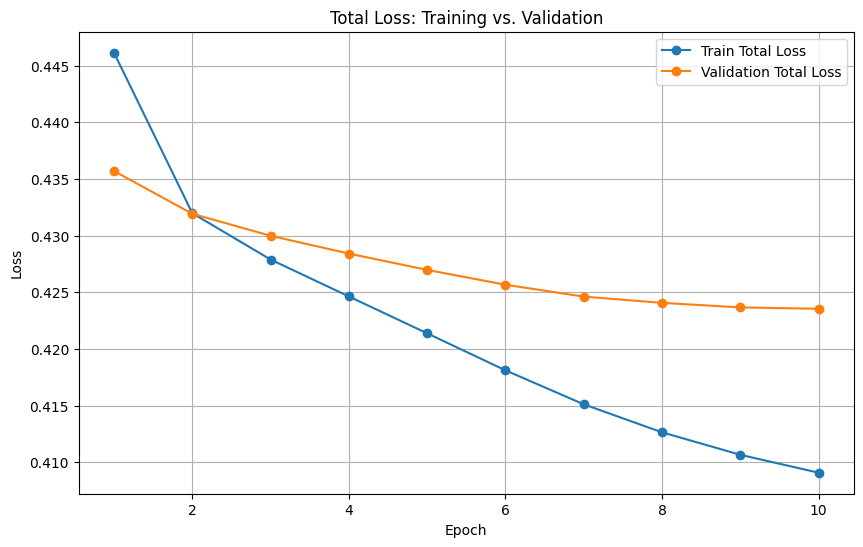

In [6]:
# --- Training Loop with Validation for Hybrid Model ---
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=1e-3)
alpha = 0.05
epochs = 10

epoch_numbers = []
train_total_losses = []
train_pairwise_losses = []
train_kl_losses = []
val_total_losses = []
val_pairwise_losses = []
val_kl_losses = []

for epoch in range(1, epochs+1):
    hybrid_model.train()
    total_loss_val = 0.0
    total_pl = 0.0
    total_kl = 0.0
    for batch in train_loader:
        user_ids, item_i, item_j, user_feats = batch
        loss, ploss, klloss = hybrid_pairwise_kl_loss(hybrid_model, hybrid_reference,
                                                       user_ids, item_i, item_j, user_feats, alpha=alpha)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss_val += loss.item()
        total_pl += ploss
        total_kl += klloss
    avg_loss = total_loss_val / len(train_loader)
    avg_pl = total_pl / len(train_loader)
    avg_kl = total_kl / len(train_loader)
    print(f"Epoch {epoch} (Train) - Loss={avg_loss:.4f}, Pairwise={avg_pl:.4f}, KL={avg_kl:.4f}")
    epoch_numbers.append(epoch)
    train_total_losses.append(avg_loss)
    train_pairwise_losses.append(avg_pl)
    train_kl_losses.append(avg_kl)

    # Validation
    hybrid_model.eval()
    val_total = 0.0
    val_pl_total = 0.0
    val_kl_total = 0.0
    with torch.no_grad():
        for batch in test_loader:
            user_ids, item_i, item_j, user_feats = batch
            loss, ploss, klloss = hybrid_pairwise_kl_loss(hybrid_model, hybrid_reference,
                                                           user_ids, item_i, item_j, user_feats, alpha=alpha)
            val_total += loss.item()
            val_pl_total += ploss
            val_kl_total += klloss
    avg_val_loss = val_total / len(test_loader)
    avg_val_pl = val_pl_total / len(test_loader)
    avg_val_kl = val_kl_total / len(test_loader)
    print(f"Epoch {epoch} (Val) - Loss={avg_val_loss:.4f}, Pairwise={avg_val_pl:.4f}, KL={avg_val_kl:.4f}")
    val_total_losses.append(avg_val_loss)
    val_pairwise_losses.append(avg_val_pl)
    val_kl_losses.append(avg_val_kl)

print("Training complete.")

plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, train_total_losses, label="Train Total Loss", marker="o")
plt.plot(epoch_numbers, val_total_losses, label="Validation Total Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Loss: Training vs. Validation")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import numpy as np
import torch
from sklearn.metrics import ndcg_score

def precision_at_k(y_true, y_pred, k=5):
    """Compute Precision@K."""
    precision_scores = []
    for true, pred in zip(y_true, y_pred):
        top_k_pred = set(pred[:k])
        relevant = set(true)
        precision = len(top_k_pred & relevant) / k
        precision_scores.append(precision)
    return np.mean(precision_scores)

def mean_average_precision(y_true, y_pred, k=5):
    """Compute Mean Average Precision (MAP)."""
    map_scores = []
    for true, pred in zip(y_true, y_pred):
        ap = 0.0
        num_hits = 0
        for i, p in enumerate(pred[:k]):
            if p in true:
                num_hits += 1
                ap += num_hits / (i + 1)
        ap = ap / min(len(true), k) if len(true) > 0 else 0
        map_scores.append(ap)
    return np.mean(map_scores)

def ndcg_at_k(y_true, y_pred, k=5):
    """Compute Normalized Discounted Cumulative Gain (NDCG@K)."""
    ndcg_scores = []
    for true, pred in zip(y_true, y_pred):
        relevance = np.array([1 if item in true else 0 for item in pred[:k]])
        true_relevance = np.zeros(k)
        true_relevance[:min(len(true), k)] = 1  # Top relevant items should be 1
        ndcg_scores.append(ndcg_score([true_relevance], [relevance]))
    return np.mean(ndcg_scores)

def evaluate_model(model, test_loader, idx2item, k=5):
    """
    Evaluate the recommendation model using Precision@K, MAP, and NDCG@K.

    Args:
    - model: Trained recommendation model
    - test_loader: DataLoader for test dataset
    - idx2item: Mapping from indices to product IDs
    - k: Number of top recommendations to consider (default=5)

    Returns:
    - Dictionary containing Precision@K, MAP, and NDCG@K
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for user_ids, item_i, item_j, user_feats in test_loader:
            scores = model(user_ids, item_i, user_feats)  # Get predicted ranking scores

            # Convert tensor to NumPy
            scores = scores.cpu().numpy()
            item_i_np = item_i.cpu().numpy()

            # Store true preferences as ranked lists
            all_labels.append([idx2item[i] for i in item_i_np])

            # Get top-k predictions
            sorted_indices = np.argsort(-scores)[:k]  # Descending order (higher score = better)
            predicted_items = [idx2item[item_i_np[i]] for i in sorted_indices]
            all_predictions.append(predicted_items)

    # Compute Evaluation Metrics
    precision = precision_at_k(all_labels, all_predictions, k=k)
    map_score = mean_average_precision(all_labels, all_predictions, k=k)
    ndcg_score_value = ndcg_at_k(all_labels, all_predictions, k=k)

    # Print Results
    print(f"Precision@{k}: {precision:.4f}")
    print(f"MAP: {map_score:.4f}")
    print(f"NDCG@{k}: {ndcg_score_value:.4f}")

    return {
        "Precision": precision,
        "MAP": map_score,
        "NDCG": ndcg_score_value
    }



In [8]:
# Evaluate the model after training
print("Evaluating Model...")
metrics = evaluate_model(hybrid_model, test_loader, idx2item, k=5)



Evaluating Model...
Precision@5: 0.9727
MAP: 1.0000
NDCG@5: 1.0000


In [9]:
############################################
# Save the Hybrid Model and Mappings
############################################
import pickle
torch.save(hybrid_model, "hybrid_model.pt")
with open("mappings.pkl", "wb") as f:
    pickle.dump({"user2idx": user2idx, "idx2item": idx2item}, f)